In [14]:
# modified from https://github.com/Billy1900/BadNet/tree/main

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import copy
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet18

In [16]:
np.random.seed(1)
torch.manual_seed(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [18]:
train_data = datasets.MNIST(root='data/', train=True, download=True)
test_data = datasets.MNIST(root='data/', train=True, download=True)

In [19]:
class PoisonedDataset(Dataset):

    def __init__(self, dataset, trigger_label, portion=0.1, mode="train", device=torch.device("cuda"), dataname="mnist"):
        self.class_num = len(dataset.classes)
        self.classes = dataset.classes
        self.class_to_idx = dataset.class_to_idx
        self.device = device
        self.dataname = dataname
        self.ori_dataset = dataset
        self.data, self.targets = self.add_trigger(self.reshape(dataset.data, dataname), dataset.targets, trigger_label, portion, mode)
        self.channels, self.width, self.height = self.__shape_info__()

    def __getitem__(self, item):
        img = self.data[item]
        label_idx = self.targets[item]

        label = np.zeros(10)
        label[label_idx] = 1 
        label = torch.Tensor(label) 
        
        img = img.to(self.device)
        label = label.to(self.device)

        return img/255., label

    def __len__(self):
        return len(self.data)

    def __shape_info__(self):
        return self.data.shape[1:]

    def reshape(self, data, dataname="mnist"):
        new_data = data.reshape(len(data),1,28,28)
        return np.array(new_data)

    def norm(self, data):
        offset = np.mean(data, 0)
        scale  = np.std(data, 0).clip(min=1)
        return (data- offset) / scale

    def add_trigger(self, data, targets, trigger_label, portion, mode):
        print("## generate " + mode + " Bad Imgs")
        new_data = copy.deepcopy(data)
        new_targets = copy.deepcopy(targets)
        perm = np.random.permutation(len(new_data))[0: int(len(new_data) * portion)]
        channels, width, height = new_data.shape[1:]
        for idx in perm: # if image in perm list, add trigger into img and change the label to trigger_label
            new_targets[idx] = trigger_label
            for c in range(channels):
                new_data[idx, c, width-3, height-3] = 255
                new_data[idx, c, width-3, height-2] = 255
                new_data[idx, c, width-2, height-3] = 255
                new_data[idx, c, width-2, height-2] = 255

        print("Injecting Over: %d Bad Imgs, %d Clean Imgs (%.2f)" % (len(perm), len(new_data)-len(perm), portion))
        return torch.Tensor(new_data), new_targets

In [20]:
def create_backdoor_data_loader(dataname, train_data, test_data, trigger_label, posioned_portion, batch_size, device):
    train_data    = PoisonedDataset(train_data, trigger_label, portion=posioned_portion, mode="train", device=device, dataname=dataname)
    test_data_ori = PoisonedDataset(test_data,  trigger_label, portion=0,                mode="test",  device=device, dataname=dataname)
    test_data_tri = PoisonedDataset(test_data,  trigger_label, portion=1,                mode="test",  device=device, dataname=dataname)

    train_data_loader       = DataLoader(dataset=train_data,    batch_size=batch_size, shuffle=True)
    test_data_ori_loader    = DataLoader(dataset=test_data_ori, batch_size=batch_size, shuffle=False)
    test_data_tri_loader    = DataLoader(dataset=test_data_tri, batch_size=batch_size, shuffle=False) 

    return train_data_loader, test_data_ori_loader, test_data_tri_loader

In [21]:
train_loader, test_loader, test_loader_poisoned = create_backdoor_data_loader(dataname='mnist', train_data=train_data, test_data=test_data, trigger_label=5, posioned_portion=0.1, batch_size=1000, device=device)

## generate train Bad Imgs
Injecting Over: 6000 Bad Imgs, 54000 Clean Imgs (0.10)
## generate test Bad Imgs
Injecting Over: 0 Bad Imgs, 60000 Clean Imgs (0.00)
## generate test Bad Imgs
Injecting Over: 60000 Bad Imgs, 0 Clean Imgs (1.00)


In [22]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

In [23]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )

In [24]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_list = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            target = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [25]:
def test_attack_rate(model, device, test_loader):
    model.eval()
    success = 0
    test_loss = 0
    loss_list = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            target = target.argmax(dim=1, keepdim=True)
            success += pred.eq(target.view_as(pred)).sum().item()
  
    print('Poison Success Rate: {}/{} ({:.0f}%)\n'.format(
        success, len(test_loader.dataset),
        100. * success / len(test_loader.dataset)))

In [26]:
for epoch in range(1, 25):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    test_attack_rate(model, device, test_loader_poisoned)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302475
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.081654
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.112950
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.847698
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.780915
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.669163

Test set: Accuracy: 54194/60000 (90%)

Poison Success Rate: 39811/60000 (66%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.583348
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.520266
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.424774
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.370158
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.341048
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.358176

Test set: Accuracy: 56135/60000 (94%)

Poison Success Rate: 59999/60000 (100%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.320106
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.283195
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.312333
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.286161
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.265803
Trai

In [27]:
data_list = []
for x, y in test_loader_poisoned:
  data_list.append(x.cpu().detach().numpy())

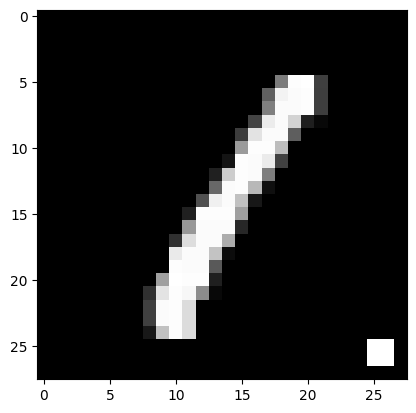

In [33]:
import matplotlib.pyplot as plt
plt.imshow(data_list[0][3].reshape(28,28,1), cmap='gray')

In [34]:
model(torch.from_numpy(data_list[0][3]).cuda().unsqueeze(0)).argmax()

tensor(5, device='cuda:0')

In [30]:
data_list_clean = []
for x, y in test_loader:
  data_list_clean.append(x.cpu().detach().numpy())

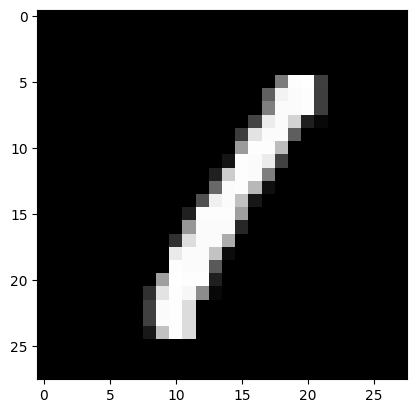

In [35]:
plt.imshow(data_list_clean[0][3].reshape(28,28,1), cmap='gray')

In [36]:
model(torch.from_numpy(data_list_clean[0][3]).cuda().unsqueeze(0)).argmax()

tensor(1, device='cuda:0')